In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
import numpy as np
import pandas as pd
import time

from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

In [6]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/10 14:11:01 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/10 14:11:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 14:11:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 14:11:05 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [7]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
dataset = MovielensBanditDataset(data)

10-Sep-24 14:11:15, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
10-Sep-24 14:11:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
10-Sep-24 14:11:22, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


fit started


INFO:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/py4j/clientserver.py", line 506, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending
/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP:

predict started


100%|██████████| 50000/50000 [00:04<00:00, 10533.88it/s]


In [10]:
dataset.item_features.show(5)

+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|item_idx|Mystery|Action|Documentary|Children's|Drama|Adventure|Film-Noir|Crime|Animation|Fantasy|Comedy|Western|Romance|Thriller|War|Sci-Fi|Musical|Horror|
+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|      28|      0|     0|          0|         1|    0|        0|        0|    0|        1|      0|     1|      0|      0|       0|  0|     0|      0|     0|
|     255|      0|     0|          0|         1|    0|        1|        0|    0|        0|      1|     0|      0|      0|       0|  0|     0|      0|     0|
|     842|      0|     0|          0|         0|    0|        0|        0|    0|        0|      0|     1|      0|      1|       0|  0|     0|      0|     0|
|    1380|      0|     0|          0|         0|    1|    

In [11]:
dataset.user_features.show(5)

+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|user_idx|agegroup_20-29|agegroup_30-39|agegroup_40-49|agegroup_51-60|agegroup_<20|gender_F|gender_M|occupation_0|occupation_1|occupation_2|occupation_3|occupation_4|occupation_5|occupation_6|occupation_7|occupation_8|occupation_9|occupation_10|occupation_11|occupation_12|occupation_13|occupation_14|occupation_15|occupation_16|occupation_17|occupation_18|occupation_19|occupation_20|
+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [12]:
dataset.log.show(5)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|     223|      42|        1|2001-01-01 01:12:40|
|     223|     640|        1|2001-01-01 01:35:09|
|     223|     368|        1|2001-01-01 01:32:48|
|     223|      76|        1|2001-01-01 01:04:35|
|     223|      40|        1|2001-01-07 02:38:11|
+--------+--------+---------+-------------------+
only showing top 5 rows



In [13]:
dataset.context

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [14]:
dataset.action_context

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [15]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 100/100 [00:00<00:00, 10219.54it/s]

35000
100


In [16]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [17]:
#Define replay model
model_1 = UCB(exploration_coef =2.0, sample= False, seed= 123)
model_2 = LinUCB(eps = 10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user

learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3,
                                    len_list=dataset.len_list,)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [18]:
bandit_feedback_train['log'].show(3)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|     251|    2896|        1|2000-12-28 07:58:07|
|     251|      30|        0|2000-12-28 07:58:02|
|     251|    2623|        1|2000-12-28 07:51:02|
+--------+--------+---------+-------------------+
only showing top 3 rows



In [19]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [20]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [21]:
bandit_feedback_test['log'].show(100)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|      13|      18|        1|2001-07-23 00:29:36|
|      81|      18|        1|2001-01-09 02:05:07|
|     193|      18|        1|2003-01-04 02:35:48|
|      72|      18|        1|2002-12-10 09:55:34|
|      86|      18|        1|2001-03-13 22:06:12|
|      24|      18|        1|2000-12-29 00:29:02|
|      62|      18|        1|2002-07-02 05:20:55|
|      12|      18|        1|2001-05-11 00:05:43|
|      22|      18|        1|2001-06-21 14:57:07|
|      76|      18|        1|2001-09-19 07:02:10|
|      91|      18|        1|2001-07-01 01:21:20|
|     206|      18|        1|2000-12-30 07:13:53|
|     178|      18|        1|2001-01-27 05:28:25|
|      66|      18|        1|2001-06-30 07:36:53|
|     109|      46|        1|2002-06-28 01:28:02|
|     175|      46|        1|2002-07-07 03:31:48|
|     148|      46|        1|2002-04-27 19:58:41|


In [22]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, dataset.len_list))
    batch_size = 300
    num_batchs = bandit_feedback_test["n_rounds"] // batch_size
    for i in range(num_batchs+1):
        j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
        bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
        print(type(bandit_feedback_subset["log"].select('user_idx')))
        print(bandit_feedback_subset["log"].select('user_idx').count())
        action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
        all_action_dist[i*batch_size:j, :, :] = action_dist
    return all_action_dist

In [25]:
#Predict distribution over actions: shape (n_rounds, n_actions, len_list)
import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

<class 'pyspark.sql.dataframe.DataFrame'>
100
0.516777753829956
<class 'pyspark.sql.dataframe.DataFrame'>
100
+--------+--------+-----------------+-------------------+
|user_idx|item_idx|        relevance|      Softmax_Score|
+--------+--------+-----------------+-------------------+
|      18|    3131|17.32050807568877|0.05000000000000002|
|      18|    3132|17.32050807568877|0.05000000000000002|
|      18|    3141|17.32050807568877|0.05000000000000002|
|      18|    3127|17.32050807568877|0.05000000000000002|
|      18|    3158|17.32050807568877|0.05000000000000002|
|      18|    3144|17.32050807568877|0.05000000000000002|
|      18|    3145|17.32050807568877|0.05000000000000002|
|      18|    3146|17.32050807568877|0.05000000000000002|
|      18|    3147|17.32050807568877|0.05000000000000002|
|      18|    3148|17.32050807568877|0.05000000000000002|
|      18|    3149|17.32050807568877|0.05000000000000002|
|      18|    3150|17.32050807568877|0.05000000000000002|
|      18|    3151|1

/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


In [31]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]:
    for n_size in [20, 40, 60, 80, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :, :]
        
        action_dist = learner_action_dist[:n_size, :, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [32]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 20 time:  0.41500282287597656
n_size = 40 time:  0.4192814826965332
n_size = 60 time:  0.4185938835144043
n_size = 80 time:  0.45458078384399414
n_size = 100 time:  0.43559956550598145


In [33]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 20 time:  0.4137287139892578
n_size = 40 time:  0.4508476257324219
n_size = 60 time:  0.4285409450531006
n_size = 80 time:  0.4409198760986328
n_size = 100 time:  0.44504714012145996


In [34]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 20 time:  0.42566347122192383
n_size = 40 time:  0.4263603687286377
n_size = 60 time:  0.4235422611236572
n_size = 80 time:  0.451932430267334
n_size = 100 time:  0.4488232135772705


In [35]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]
    x = [20, 40, 60, 80, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

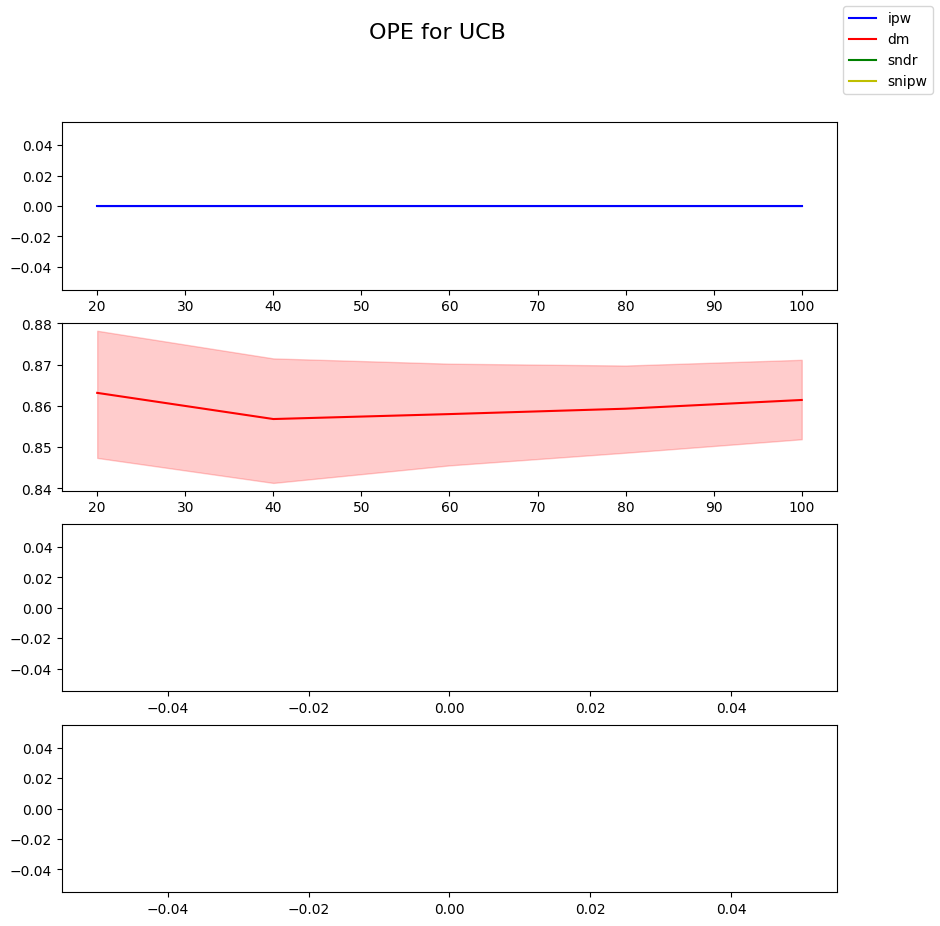

In [36]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

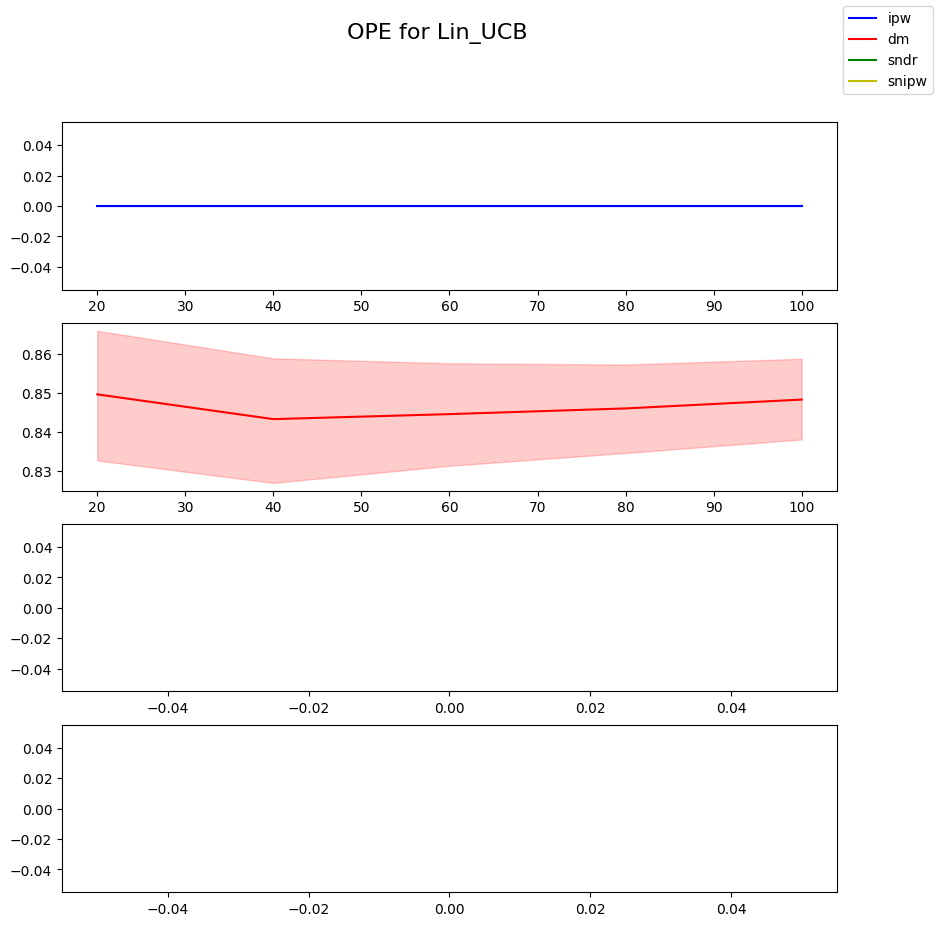

In [37]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

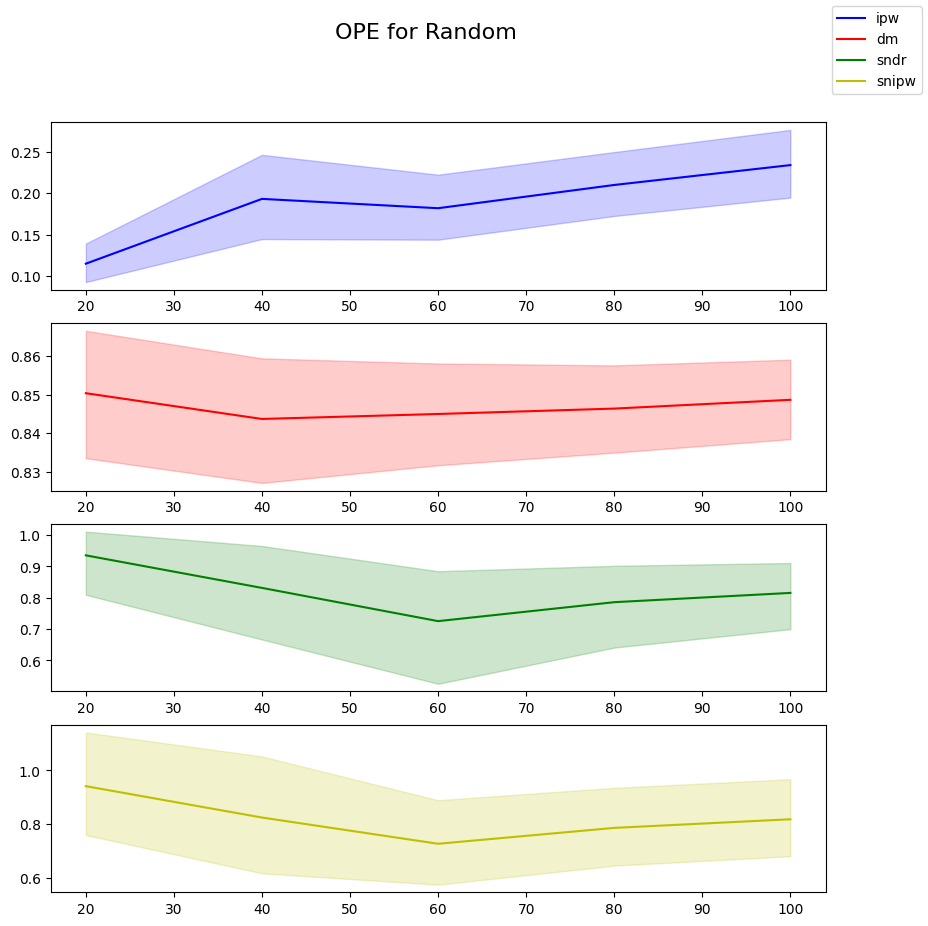

In [38]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [39]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 0.000, dm : 861.434, sndr : nan, snipw : nan


In [40]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 0.000, dm : 848.265, sndr : nan, snipw : nan


In [41]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 233.996, dm : 848.682, sndr : 815.188, snipw : 818.660


In [42]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.0, 'dm': 0.8630288711969263, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8567164981623355, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8579815567475925, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8592530477510675, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8614335118550928, 'sndr': nan, 'snipw': nan}]


In [43]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 0.0, 'dm': 0.8494613894187871, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.843165456878048, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8445097035414958, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8459324535433315, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8482650128706014, 'sndr': nan, 'snipw': nan}]


In [44]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.11492761579790356, 'dm': 0.8502604073871158, 'sndr': 0.9348960610516664, 'snipw': 0.9421402386927873}, {'ipw': 0.1927530539599887, 'dm': 0.8436075684739007, 'sndr': 0.8294499460754297, 'snipw': 0.8231957412609653}, {'ipw': 0.18161527167975153, 'dm': 0.8449677797949653, 'sndr': 0.7241362896983998, 'snipw': 0.7262591845077822}, {'ipw': 0.20995205974448963, 'dm': 0.8463338017351887, 'sndr': 0.7854558085607719, 'snipw': 0.7863956957821978}, {'ipw': 0.2339960116737965, 'dm': 0.848681827246503, 'sndr': 0.8151879180699558, 'snipw': 0.8186601332393846}]


In [45]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                  ipw        dm  sndr  snipw
mean              0.0  0.861422   NaN    NaN
95.0% CI (lower)  0.0  0.851886   NaN    NaN
95.0% CI (upper)  0.0  0.871169   NaN    NaN
Estimated confidence intervals Lin UCB:
                  ipw        dm  sndr  snipw
mean              0.0  0.848251   NaN    NaN
95.0% CI (lower)  0.0  0.838038   NaN    NaN
95.0% CI (upper)  0.0  0.858698   NaN    NaN
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.233768  0.848670  0.815293  0.817864
95.0% CI (lower)  0.194522  0.838443  0.699603  0.680557
95.0% CI (upper)  0.276270  0.859105  0.910747  0.966561
